Example of parameter uncertainties in fits
=====

First we generate random data to fill a histogram using the PDF for a normal distribution.

In [1]:
import ROOT as r
# make only static plots
%jsroot off  

C system headers (glibc/Xcode/Windows SDK) must be installed.
In file included from input_line_4:36:
/sfs/ceph/standard/phys56xx/miniforge3/envs/phys56xx/bin/../lib/gcc/x86_64-conda-linux-gnu/13.3.0/include/c++/cassert:44:10: fatal error: 'assert.h' file not found
#include <assert.h>
         ^~~~~~~~~~
input_line_35:1:10: fatal error: 'dlfcn.h' file not found
#include "dlfcn.h"
         ^~~~~~~~~


In [8]:
h=r.TH1F("h1","Random normal;x;#events",100,-4,4)
h.Sumw2()  # for error bars (and proper errors if using weighted data)
# here we use a custom function instead of the built in one to show the work more explicitly
gaus=r.TF1("mygaus","[0]*exp(-(x-[1])*(x-[1])/[2]/[2])",-4,4)
gaus.SetParameters(1,0,1)
h.FillRandom("gaus",20000)

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


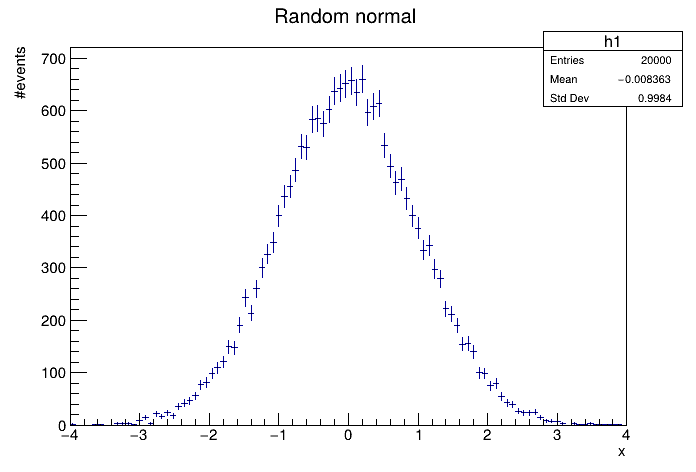

In [9]:
tc=r.TCanvas()
h.Draw()
tc.Draw()

Now we fit the data using a Gaussian.  (We'll discuss the fitting interface in ROOT in more detail later).

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      95.2071
NDf                       =           90
Edm                       =  7.40355e-06
NCalls                    =           73
Constant                  =      642.168   +/-   5.54068     
Mean                      =   -0.0040809   +/-   0.00704413  
Sigma                     =      1.39967   +/-   0.00692288  


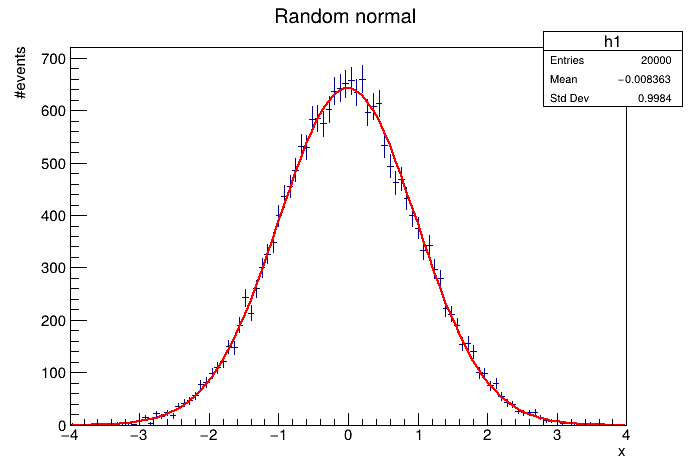

In [10]:
tc=r.TCanvas()
gaus.SetParameter(0,h.GetMaximum())  # adjust starting parameter
gaus.SetParName(0,"Constant");
gaus.SetParName(1,"Mean");
gaus.SetParName(2,"Sigma");
h.Fit("mygaus")
tc.Draw()
par=[0]*3
err=[0]*3
for i in range(3):
    par[i]=gaus.GetParameter(i)
    err[i]=gaus.GetParError(i)
chi2_fit=gaus.GetChisquare();

Notice that the fitter provided the best fit values as well as an estimate of the parameter uncertainty.  Try changing the number of entries generated for the histogram.  You will see the parameter (relative) errors shrinking or increasing if more or fewer data are generated.  Larger data sets constrain models better! 

Next, let's get a feeling for where these parameter errors are coming from.  We'll look at parameter(1), the fitted mean.

In [11]:
# Generate a range of values around the best fit value
import numpy as np
vals=np.linspace(par[1]-3*err[1],par[1]+3*err[1],100)

In [12]:
# for each value or the mean we minimize the other parameters, keeping the mean fixed
gaus.FixParameter(1,0)
grb=r.TGraph()
grb.SetTitle("Chi^2 vs param [1];param [1];Chi^2")
for b in vals:
    gaus.SetParameter(1,b)
    h.Fit("mygaus","q0")
    grb.SetPoint(grb.GetN(),b,gaus.GetChisquare())
gaus.ReleaseParameter(1)

Draw the contour of $\chi^2$ values, showing the dependence on the mean, eg $\chi^2(par[1];par[0],par[2])$.  We see that the $\chi^2$ has a parabolic shape to a large degree in the vicinity of the minimum.

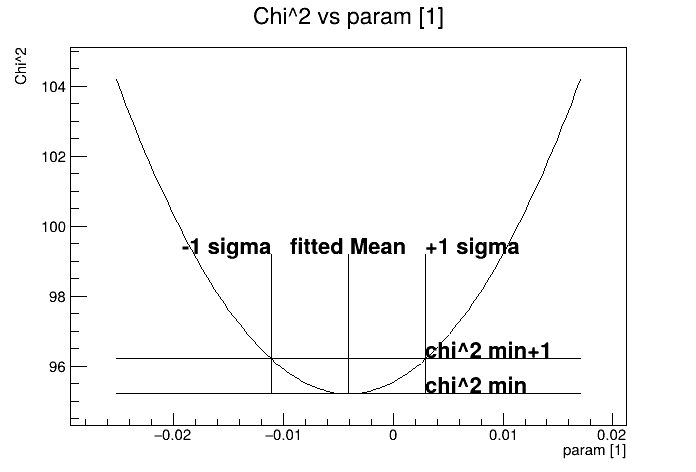

In [13]:
tc.Clear()
grb.Draw("al")
min=r.TLine(vals[0],chi2_fit,vals[-1],chi2_fit)
minplus1=r.TLine(vals[0],chi2_fit+1,vals[-1],chi2_fit+1)
nom1=r.TLine(par[1],chi2_fit,par[1],chi2_fit+4)
nom1minus=r.TLine(par[1]-err[1],chi2_fit,par[1]-err[1],chi2_fit+4)
nom1plus=r.TLine(par[1]+err[1],chi2_fit,par[1]+err[1],chi2_fit+4)

# Alignment options, see TAttText Class Reference
left=11
center=21
right=31
txt=r.TText()
txt.SetTextAlign(center);
txt.DrawText(par[1],chi2_fit+4,"fitted Mean")
txt.SetTextAlign(right);
txt.DrawText(par[1]-err[1],chi2_fit+4,"-1 sigma")
txt.SetTextAlign(left);
txt.DrawText(par[1]+err[1],chi2_fit+4,"+1 sigma")
txt.DrawText(par[1]+err[1],chi2_fit,"chi^2 min")
txt.DrawText(par[1]+err[1],chi2_fit+1,"chi^2 min+1")
min.Draw()
minplus1.Draw()
nom1.Draw()
nom1minus.Draw()
nom1plus.Draw()
tc.Draw()

Here we fit the region around the minimum to illustrate the parabolic shape. 

****************************************
Minimizer is Linear / Migrad
Chi2                      =  2.54962e-08
NDf                       =           30
p0                        =      95.5428   +/-   7.0253e-06  
p1                        =      164.505   +/-   0.0029379   
p2                        =      20152.8   +/-   0.343827    


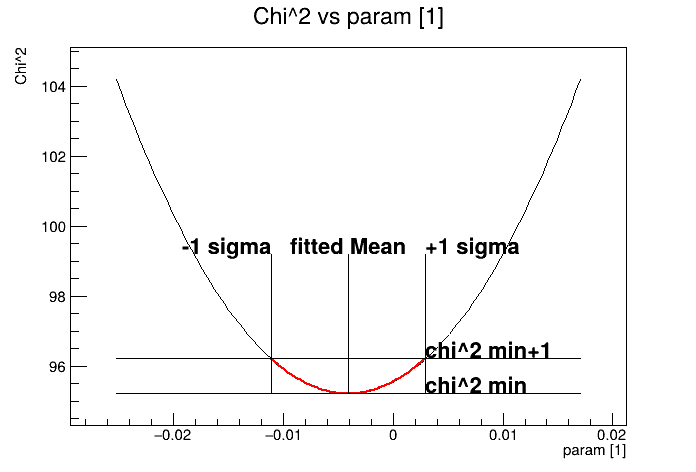

In [14]:
from math import sqrt
grb.Fit("pol2","","",par[1]-err[1],par[1]+err[1])
tc.Draw()

Using the curvture at the $\chi^2$ minimum, calculate the (parabolic) uncertainty on the mean.  This is the amount of variation needed to go from the $\chi^2$ minimum to $\chi^2$ minimum + 1.

In [15]:
pol2=grb.GetFunction("pol2")
d2X2d2p=pol2.GetParameter(2)*2
dx=sqrt(2/d2X2d2p)
print(f"Fitted error for param[1]:                                       {err[1]:.{4}}")
print(f"Error calculated from this 2nd derivative of chi^2 wrt param[1]: {dx:.{4}}")

Fitted error for param[1]:                                       0.007044
Error calculated from this 2nd derivative of chi^2 wrt param[1]: 0.007044


We see here that the parameter error quoted in the fit is directly related to the (parabolic) curvature of the chi^2 around the minimum.  The range of values of the parameter satisfying $\chi^2<\chi^2_{min}+1$ defines the "1-sigma" uncertainty of the fit parameter.

If this is a good estimation of the parameter uncertainty, how would you expect the fit parameters to vary if we repeated this fitting experiment many times on independently generated data samples?

**You will explore this question in this week's exercise!**